## Set up

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("/mnt/nfs-1/t2t/data")
tmp_dir = os.path.expanduser("/mnt/nfs-1/t2t/tmp")
train_dir = os.path.expanduser("/mnt/nfs-1/t2t/train")
checkpoint_dir = os.path.expanduser("/mnt/nfs-1/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

/home/jovyan/.conda/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [5]:
import matplotlib.pyplot as plt

In [20]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_cifar10"
model_name = "img2img_transformer"

In [21]:
hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

In [22]:
translate_model_7 = registry.model(model_name)(hp, Modes.EVAL)

In [24]:
translate_model_7.set_mode(Modes.PREDICT)

In [25]:
img2img_cifar10 = problems.problem("img2img_cifar10")

In [26]:
dataset = img2img_cifar10.dataset(Modes.PREDICT, "/mnt/nfs-1/t2t/data-1/")

INFO:tensorflow:Reading data files from /mnt/nfs-1/t2t/data-1/image_cifar10_plain-dev*


[2018-05-21 21:33:31,058] Reading data files from /mnt/nfs-1/t2t/data-1/image_cifar10_plain-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


[2018-05-21 21:33:31,071] partition: 0 num_data_files: 1


In [27]:
# Get one example using tf.data via t2t (in eager mode)
example = tfe.Iterator(dataset).next()

In [28]:
reshaped_input = tf.reshape(example["inputs"], [1, 8, 8, 3])

In [ ]:
example["targets"]

### Calling model in eval mode

In [30]:
foo = tf.reshape(example["targets"], [1, 32, 32, 3])

In [31]:
ckpt_path = "/mnt/nfs-1/testing/tune-0518-1723-e339/output/model.ckpt-9001"

In [37]:
import numpy as np

translate_model_7.set_mode(Modes.EVAL)

with tfe.restore_variables_on_create(None):
    for count, example in enumerate(tfe.Iterator(dataset)):
      if count >= 1:
        break

      example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
      example["targets"] = foo

      predictions, other = translate_model_7(example)

INFO:tensorflow:Using variable initializer: uniform_unit_scaling


[2018-05-21 21:34:57,127] Using variable initializer: uniform_unit_scaling


In [ ]:
predictions

In [39]:
p = predictions.numpy()
x_max = p.shape[1] # X-position in image
y_max = p.shape[2] # Y-position in image
c_max = p.shape[3] # Color channel (r,g,b)

# The image we will populate
image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

batch_idx = 0

for x in range(0, x_max):
    for y in range(0, y_max):
        for c in range(0, c_max):
            # Get the index of the greatest value in p[0][x][y][c]
            val = np.argmax(p[0][x][y][c])
            image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))

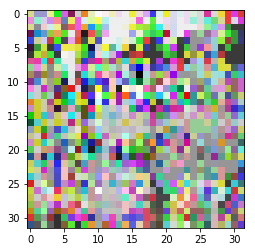

In [41]:
plt.imshow(image[0])

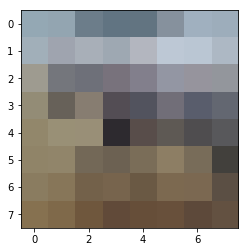

In [170]:
plt.imshow(example["inputs"].numpy())

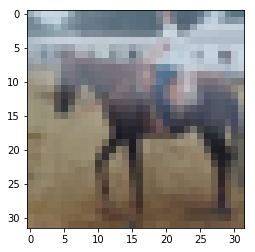

In [171]:
plt.imshow(example["targets"].numpy())

so no we're not exactly producing images of horses yet. but maybe if "big data" we would be? 😬 Perhaps it would be doing a larger training run.

So perhaps eval mode is fine for producing predictions it just does extra work in computing the loss betweent this prediction and an expected target?

Below are exploration of (1) running model in predict mode and (2) running model.predict.

### Calling model in predict mode

But what about PREDICT mode?

In [119]:
import numpy as np

translate_model_1.set_mode(Modes.PREDICT)

with tfe.restore_variables_on_create(ckpt_path):
    for count, example in enumerate(tfe.Iterator(dataset)):
      if count >= 1:
        break

      example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
      example["targets"] = foo
      # Perhaps in PREDICT mode it's only using the shape of the targets and not the contents?

      predictions, other = translate_model_1(example)

INFO:tensorflow:Using variable initializer: uniform_unit_scaling


[2018-05-03 22:04:24,233] Using variable initializer: uniform_unit_scaling


In [120]:
predictions.shape

TensorShape([Dimension(1), Dimension(32), Dimension(1), Dimension(1), Dimension(256)])

In [121]:
predictions

<tf.Tensor: id=121150, shape=(1, 32, 1, 1, 256), dtype=float32, numpy=
array([[[[[ 0.02728007,  0.2610966 , -0.08272113, ..., -0.04751465,
            0.34203047, -0.3122358 ]]],


        [[[ 0.17192686,  0.3652917 , -0.13939053, ..., -0.03549231,
            0.22401936, -0.1782961 ]]],


        [[[ 0.30669683,  0.35906962, -0.3016665 , ..., -0.04809308,
            0.21740052, -0.26972783]]],


        ...,


        [[[ 0.11051102, -0.08833907, -0.24874426, ...,  0.01420414,
            0.56916773, -0.12009691]]],


        [[[ 0.54575425, -0.12090082,  0.11244182, ...,  0.2518709 ,
            0.5514451 , -0.13175994]]],


        [[[ 0.1710438 , -0.19372037, -0.19395082, ...,  0.24723886,
            0.5171461 ,  0.01972612]]]]], dtype=float32)>

### Using model.infer

But what about model.infer?

In [ ]:
import numpy as np

translate_model_1.set_mode(Modes.PREDICT)

with tfe.restore_variables_on_create(ckpt_path):
    for count, example in enumerate(tfe.Iterator(dataset)):
      if count >= 1:
        break

      example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
      example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])

      predictions = translate_model_1.infer(example)